In [1]:
# Practice by Young
# Last updated 07/11/2022

In [1]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime
import pandas as pd

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

In [14]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


In [15]:
# Query the session using .observers() to generate a list
qry = session.query(ImageData.observers)

# Locate all that are distinct
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


/tmp/ipykernel_108/3574455917.py:10: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  qry = qry.distinct().limit(10).all()


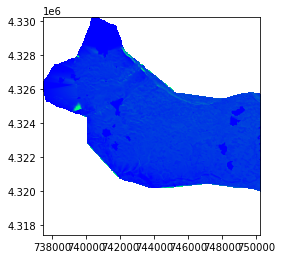

In [28]:
sensor = 'ASO Inc.'

# Form a query on the Images table that returns Raster collection dates
qry = session.query(func.ST_AsTiff(ImageData.raster))

# Filter for UAVSAR data
qry = qry.filter(ImageData.observers == sensor)

# Grab the unique dates
qry = qry.distinct().limit(10).all()

# result = qry.all() #session.query(ImageData.raster).limit(1).all()

# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
# result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, qry)

# Plot the georeferenced image 
show(datasets[0], vmax=1.2, vmin=0, cmap='winter')

# Close the dataset
#datasets[0].close()

# # View the returned dataframe!
# print(df.head())
# print(f'{len(df.index)} records returned!')

# Close your session to avoid hanging transactions
session.close()

In [34]:
array = datasets[0].read(1)

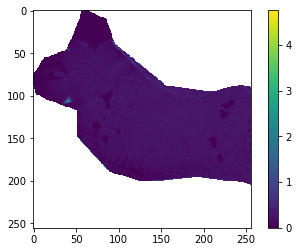

In [36]:
plt.imshow(array)
plt.colorbar()

In [31]:
trsform = datasets[0].transform

In [33]:
datasets[0].crs

CRS.from_epsg(26912)

In [32]:
trsform * (0,0)

(737454.0000015452, 4330217.999887472)

In [24]:
engine, session = get_db(db_name)

# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'dem').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0], vmax=1.2, vmin=0, cmap='winter')

# Close the dataset
datasets[0].close()
session.close()

/tmp/ipykernel_108/2657650198.py:4: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'dem').limit(1).all()


IndexError: list index out of range

In [23]:
datasets[0]

<closed DatasetReader name='/vsimem/c0a9f4b9-58d0-473a-ab38-d3ea082668f9/c0a9f4b9-58d0-473a-ab38-d3ea082668f9.tif' mode='r'>

In [12]:
# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

/tmp/ipykernel_108/443075858.py:5: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth').limit(1).all()


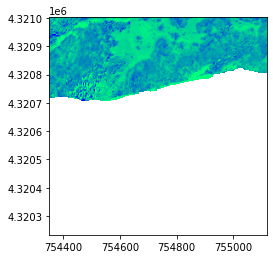

In [10]:
# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0], vmax=1.2, vmin=0, cmap='winter')

# Close the dataset
datasets[0].close()
session.close()

In [10]:
# Airborne sensor from list above
sensor = 'UAVSAR team, JPL'

# Form a query on the Images table that returns Raster collection dates
qry = session.query(ImageData.date)

# Filter for UAVSAR data
qry = qry.filter(ImageData.observers == sensor)

# Grab the unique dates
qry = qry.distinct()

# Execute the query 
dates = qry.all() 

# Clean up the dates 
dates = [d[0] for d in dates] 
dlist = [str(d) for d in dates]
dlist = ", ".join(dlist)
print('%s flight dates are: %s' %(sensor, dlist))

# Find all the snow pits done on these days
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
qry = qry.filter(SiteData.date.in_(dates))

# Return a geopandas df
df = query_to_geopandas(qry, engine)

# View the returned dataframe!
print(df.head())
print(f'{len(df.index)} records returned!')

# Close your session to avoid hanging transactions
session.close()

UAVSAR team, JPL flight dates are: 2020-02-12, 2020-02-13, 2020-01-31, 2020-02-01, 2020-03-11, 2020-02-21
                             geom site_id        date
0  POINT (742229.000 4326414.000)    2C12  2020-02-12
1  POINT (745243.000 4322637.000)    6S26  2020-02-12
2  POINT (744824.000 4323962.000)    5N32  2020-02-12
3  POINT (744639.000 4323010.000)    FL1B  2020-02-12
4  POINT (743604.000 4324202.000)    5N24  2020-02-12
142 records returned!


In [11]:
# Pick a day from the list of dates
dt = dates[0] 

# Find all the snow pits done on these days 
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
qry = qry.filter(SiteData.date == dt)

# Return a geopandas df
df_exact = query_to_geopandas(qry, engine)

print('%s pits overlap with %s on %s' %(len(df_exact), sensor, dt))

# View snows pits that align with first UAVSAR date
df_exact.head()

40 pits overlap with UAVSAR team, JPL on 2020-02-12


,geom,site_id,date
0,POINT (742229.000 4326414.000),2C12,2020-02-12
1,POINT (745243.000 4322637.000),6S26,2020-02-12
2,POINT (744824.000 4323962.000),5N32,2020-02-12
3,POINT (744639.000 4323010.000),FL1B,2020-02-12
4,POINT (743604.000 4324202.000),5N24,2020-02-12


In [12]:
import icepyx

In [13]:
# query all the sites by site id
qry = session.query(SiteData.site_id).distinct()

# filter out the Grand Mesa IOP sites (this also removes Grand Mesa Time Series sites, but okay for this example)
qry = qry.filter(SiteData.site_name != 'Grand Mesa') # != is "not equal to"

# second filter on open canopy sites
qry = qry.filter(SiteData.tree_canopy == 'No Trees')

# execute the query
ts_sites = qry.all()

# clean up to print a list of sites
ts_sites = [s[0] for s in ts_sites]
ts_sites_str = ", ".join(ts_sites)
print('list of Time Series sites:\n', ts_sites_str)

list of Time Series sites:
 JPL 1, Open, Open Flat, Joe Wright, Open 2, BA Flux Tower, Open 4, Saddle, Banner Open, Panorama Dome, Senator Beck, Swamp Angel, JPL 2, Mores Creek Summit, CUES, SNB 1, Michigan River, HQ Met Station, Alta Collins, Atwater, LDP Open, Gothic, Tower 4, Open 6


In [15]:
# 1. use the list of Time Series sites from above 
sites = ts_sites

# setup the colorbar
cmap = matplotlib.cm.get_cmap('viridis')

# 3. loop over sites and select the data parameter ('temperature')
for i, site in enumerate(sites):
    
    # query the database by site and for temperature profile data 
    qry = session.query(LayerData).filter(LayerData.site_id.in_([site])).filter(LayerData.type == 'temperature') 
    
    # convert to pandas dataframe  
    df = query_to_pandas(qry, engine) 

In [24]:
df.keys()

Index(['site_name', 'date', 'time_created', 'time_updated', 'id', 'doi',
       'date_accessed', 'instrument', 'type', 'units', 'observers', 'latitude',
       'longitude', 'northing', 'easting', 'elevation', 'utm_zone', 'geom',
       'time', 'depth', 'site_id', 'pit_id', 'bottom_depth', 'comments',
       'sample_a', 'sample_b', 'sample_c', 'value', 'flags'],
      dtype='object')

In [20]:
lats = df['latitude'].values
lons = df['longitude'].values

In [22]:
lats

array([38.92667, 38.92667, 38.92667, 38.92667, 38.92667, 38.92667,
       38.92667, 38.92667, 38.92667, 38.92667, 38.92657, 38.92657,
       38.92657, 38.92657, 38.92657, 38.92657, 38.92657, 38.92657,
       38.92657, 38.92657, 38.92657, 38.92663, 38.92663, 38.92663,
       38.92663, 38.92663, 38.92663, 38.92663, 38.92663, 38.92663,
       38.92663, 38.92658, 38.92658, 38.92658, 38.92658, 38.92658,
       38.92658, 38.92658, 38.92658, 38.92658, 38.92658, 38.92658,
       38.92658, 38.92658, 38.92658, 38.92658, 38.92664, 38.92664,
       38.92664, 38.92664, 38.92664, 38.92664, 38.92664, 38.92664,
       38.92664, 38.92664, 38.92664, 38.92664, 38.92664, 38.92664,
       38.92668, 38.92668, 38.92668, 38.92668, 38.92668, 38.92668,
       38.92668, 38.92668, 38.92668, 38.92668, 38.92668, 38.92668,
       38.92668, 38.92682, 38.92682, 38.92682, 38.92682, 38.92682,
       38.92682, 38.92682, 38.92682, 38.92682, 38.92682, 38.92681,
       38.92681, 38.92681, 38.92681, 38.92681, 38.92681, 38.92

In [28]:
df['date']

0      2020-02-01
1      2020-02-01
2      2020-02-01
3      2020-02-01
4      2020-02-01
          ...    
99     2020-04-27
100    2020-04-27
101    2020-04-27
102    2020-04-27
103    2020-04-27
Name: date, Length: 104, dtype: object

In [29]:
# import
from sliderule import icesat2

# initialize
icesat2.init("icesat2sliderule.org", verbose=True)

# region of interest
region = [ {"lon":-105.82971551223244, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 39.81983728534918} ]

# request parameters
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# make request
rsps = icesat2.atl06p(parms, "nsidc-s3")

ModuleNotFoundError: No module named 'sliderule'

In [31]:
# import
from sliderule import icesat2

# initialize
icesat2.init("icesat2sliderule.org", verbose=True)

# region of interest
region = [ {"lon":-105.82971551223244, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 39.81983728534918} ]

# request parameters
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# make request
rsps = icesat2.atl06p(parms, "nsidc-s3")


INFO:sliderule.icesat2:Identified 94 resources to process
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20181029095325_04700106_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20181030213737_04930102_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20181231184124_00510202_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20190202170917_05540202_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20190504124854_05540302_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20190128053323_04700206_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20190331023705_00280306_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20181201082105_09730106_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated on ATL03_20181103212922_05540102_005_01.h5 ...
INFO:sliderule.sliderule:atl06 processing initiated

In [53]:
rsps[rsps['delta_time'] in "2018-11-03"]

TypeError: 'in <string>' requires string as left operand, not Series

In [35]:
rsps.keys()

Index(['delta_time', 'distance', 'rgt', 'dh_fit_dx', 'rms_misfit', 'cycle',
       'spot', 'h_sigma', 'segment_id', 'w_surface_window_final', 'pflags',
       'gt', 'n_fit_photons', 'h_mean', 'dh_fit_dy', 'geometry'],
      dtype='object')

(4440000.0, 4460000.0)

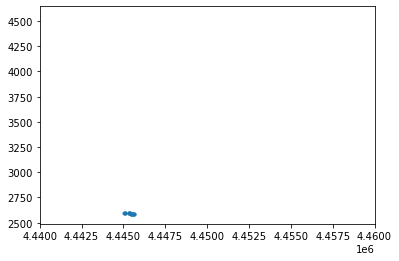

In [49]:
plt.plot(rsps[:2000]['distance'], rsps[:2000]['h_mean'], '.')
plt.xlim(4440000, 4460000)